# CS145: Project 3 | Google Political Advertising is a 4.0

## Collaborators:
Please list the names and SUNet IDs of your collaborators below:
* John Chuter, jchuter

## Project Overview

---
Who targets whom with political advertising? 

First, to define the "who": the Democrat and Republican parties in the US. For the "whom": the groups within the US distinct by sex, age, and state. 

There are many sub-questions within that main question. Republicans target which group the most, which the least, and how does that compare to Democrats? The answers will address how the Republican and Democrat parties differ in their target demographics, broadly and precisely.

For example, broadly speaking, which party spends the most on political advertising? More precisely, how much do Republicans spend targeting old males in Texas, versus young females in New York? 

---


## Analysis of Dataset

This dataset ["Google Political Ads"](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=google_political_ads&page=dataset) broadly covers how Google Ads have been used politically. It includes multiple tables with a sum size of ~300mb. 

For exploration of the above question, those of relevant interest include `campaign_targeting`, `advertiser_stats`,  and `geo_spend`.

First, `campaign_targeting`. This table is ~30mb, and details features about ad campaigns since August 2018 to the present. These include both the demographic information (features on age, gender, location) of the campaign, and the specific advertiser id responsible for it. It's primary key is `campaign_id`, `advertiser_id`, to disinguish specific advertisers who partook in specific campaigns. This dataset is of particular value for the machine learning task, described later in the appropriate section.

Next, `advertiser_stats`. This identifies each advertiser, giving them custom ids `advertiser_id` and providing official names. These names can be researched, and labeled as Democrat or Republican. This can then be used in combination with the `campaign_targeting` table to identify advertiser parties with specific campaigns.

Finally, `geo_spend`. This table offers a broad idea of how much money is being spent across the world (and across states). From this we can learn how much money is spent on advertising in the US, to better realize the scope of advertising and which areas (part of the "whom") it's affecting most.



## Data Exploration

In [0]:
from google.colab import auth
auth.authenticate_user()
project_id = "cs145-p3-actual"

In [0]:
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [0]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## 0. Let's first define "Republican" and "Democrat".
In order to analyze along partisan lines, we must first define who belongs to what party.

### By spending, which are top 5 democrat and republican advertisers?
With this, we can analyze partisan data.
Because this dataset lacks explicit party affiliation, with this query we can manually identify the main advertiser affiliations.

Note: this is in flux. For example, `Michael Bloomberg 2020` was nowhere on these lists as of yesterday, but now he's the top-spending Democrat.

In [39]:
%%bigquery --project $project_id

SELECT advertiser_id, advertiser_name
FROM `bigquery-public-data.google_political_ads.advertiser_stats`
where regions like '%US%'
order by spend_usd desc
LIMIT 30

,advertiser_id,advertiser_name
0,AR488306308034854912,TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE
1,AR230475229367894016,SENATE LEADERSHIP FUND
2,AR458000056721604608,MIKE BLOOMBERG 2020 INC
3,AR470291909525372928,CONGRESSIONAL LEADERSHIP FUND
4,AR432709227698454528,TOM STEYER 2020
5,AR105500339708362752,"DONALD J. TRUMP FOR PRESIDENT, INC."
6,AR101121809528651776,"PETE FOR AMERICA, INC."
7,AR120847323008860160,DEDICATEDEMAILS.COM
8,AR157291735423123456,NRCC
9,AR140403236820484096,Need to Impeach


### The advertiser classifications:

Republicans:
1.		AR488306308034854912 TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE
2.	AR230475229367894016 SENATE LEADERSHIP FUND
3.	AR470291909525372928 CONGRESSIONAL LEADERSHIP FUND
4.	AR105500339708362752 DONALD J. TRUMP FOR PRESIDENT, INC.
5. AR120847323008860160 DEDICATEDEMAILS.COM
6.	AR157291735423123456	NRCC
7.	AR194446432348930048	NRSC
8.	AR276637125548441600	REPUBLICAN NATIONAL COMMITTEE
9.	AR424466463902924800	AMERICANS FOR PROSPERITY ACTION INC
10.	AR89517838687010816		PRIORITIES USA ACTION & HOUSE MAJORITY PAC

IDs only:
- (AR488306308034854912,
AR230475229367894016,
AR470291909525372928,
AR105500339708362752,
AR120847323008860160,
AR157291735423123456,
AR194446432348930048,
AR276637125548441600,
AR424466463902924800,
AR89517838687010816)


Democrats:
1.	AR458000056721604608 MIKE BLOOMBERG 2020 INC
2.	AR432709227698454528 TOM STEYER 2020
3.	AR101121809528651776 PETE FOR AMERICA, INC.
4.	AR140403236820484096 Need to Impeach
5.	AR485896728302583808 WARREN FOR PRESIDENT, INC.
6.	AR329053043867779072 PRIORITIES USA ACTION & SMP
7.	AR383080296477622272	BERNIE 2020
8.	AR271344076572327936	INDEPENDENCE USA PAC
9.	AR492809907662225408	BETO FOR TEXAS
10.	AR50710026028843008	KAMALA HARRIS FOR THE PEOPLE

IDs only:
- (
AR458000056721604608,
AR432709227698454528,
AR101121809528651776,
AR140403236820484096,
AR485896728302583808,
AR329053043867779072,
AR383080296477622272,
AR271344076572327936,
AR492809907662225408,
AR50710026028843008
)

## 1. Spending

### 1a: Which states are targeted?
By spending, which states are the top 10?
This relates to the previous question of what areas are most targeted by political advertising, to better understand the "whom".

In [0]:
"%%bigquery --project $project_id

SELECT 
  country_subdivision_primary as State,
  sum(spend_usd) usd
FROM `bigquery-public-data.google_political_ads.geo_spend`
WHERE country='US'
GROUP BY country_subdivision_primary
ORDER BY usd desc
limit 10

,State,usd
0,US-FL,13102000
1,US-CA,11853400
2,US-TX,7514600
3,US-AZ,5693400
4,US-TN,5532600
5,US-NY,5427600
6,US-MO,5221400
7,US-PA,4443100
8,US-NV,4411500
9,US-IN,4366500


### 1b: About the who: how much is being spent (USD) on political advertising in US?
How big of a deal is political advertising in the US?


In [0]:
%%bigquery --project $project_id

SELECT sum(spend_usd) as total_USD
FROM `bigquery-public-data.google_political_ads.advertiser_stats`
where regions like '%US%'

,total_USD
0,122045200


### 1c: More specifically, how much is spent (USD), by party?
Who's doing most of the advertising?


Spending by top 5 advertisers of each party:

In [41]:
%%bigquery --project $project_id

select 
(SELECT sum(spend_usd) as total_USD
FROM `bigquery-public-data.google_political_ads.advertiser_stats`
where regions like '%US%'
and advertiser_id in (
'AR488306308034854912',
'AR230475229367894016',
'AR470291909525372928',
'AR105500339708362752',
'AR120847323008860160'
)) as republican_spending,

(SELECT sum(spend_usd) as total_USD
FROM `bigquery-public-data.google_political_ads.advertiser_stats`
where regions like '%US%'
and advertiser_id in (
'AR458000056721604608',
'AR432709227698454528',
'AR101121809528651776',
'AR140403236820484096',
'AR485896728302583808'
)) as democrat_spending

,republican_spending,democrat_spending
0,26035600,19464100


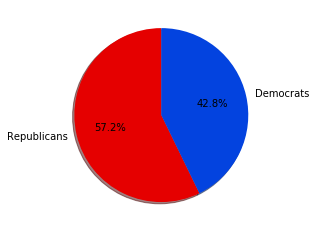

In [42]:
labels = 'Republicans', 'Democrats'
colors = ['xkcd:red', 'xkcd:blue']
spending = [26035600, 19464100]
fig1, ax1 = plt.subplots()
ax1.pie(spending, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()


*NOTE*: including this data to demonstrate two caveats to this analysis. 

1. As of yesterday, Dec 2:
"Republicans spend significantly more than Democrats on advertising (~20% of total, or 150% of what Democrats do)."
Today, Dec 3, that is less true; it's now a 15% difference of the total.

2. Also, when we expand to the top 10, the figures shift.

Spending by top 10 advertisers of each party:

In [40]:
%%bigquery --project $project_id

select 
(SELECT sum(spend_usd) as total_USD
FROM `bigquery-public-data.google_political_ads.advertiser_stats`
where regions like '%US%'
and advertiser_id in (
'AR488306308034854912',
'AR230475229367894016',
'AR470291909525372928',
'AR105500339708362752',
'AR120847323008860160',
'AR157291735423123456',
'AR194446432348930048',
'AR276637125548441600',
'AR424466463902924800',
'AR89517838687010816')) as republican_spending,

(SELECT sum(spend_usd) as total_USD
FROM `bigquery-public-data.google_political_ads.advertiser_stats`
where regions like '%US%'
and advertiser_id in (
'AR458000056721604608',
'AR432709227698454528',
'AR101121809528651776',
'AR140403236820484096',
'AR485896728302583808',
'AR329053043867779072',
'AR383080296477622272',
'AR271344076572327936',
'AR492809907662225408',
'AR50710026028843008'
)) as democrat_spending

,republican_spending,democrat_spending
0,36375700,30350700


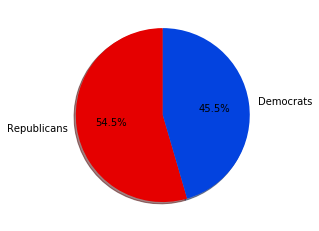

In [43]:
labels = 'Republicans', 'Democrats'
colors = ['xkcd:red', 'xkcd:blue']
spending = [36375700, 30350700]
fig1, ax1 = plt.subplots()
ax1.pie(spending, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

Again, summing across the top 10 advertisers for each party, Republican still spend more -albeit now only 54.5 to 45.5. 

Expanding out to 20, 100, etc parties might change the picture more.

However, this also provides a nice insight into both parties: Republican spending is centralized, whereas Democrat spending is more decentralized. Democrats are split between numerous advertisers (largely specific to candidates) whereas Republicans are more unified.

## 2. Targeting, Count
We'll first pass through the relationships between ad count and party, ad count and age, then ad count and sex. 

Next, we'll look a little more closely by combining these, looking at ad count with respect to sex and age.

Finally, we'll examine party differences along these features, looking at ad count with respect to age and party, sex and party. 


### 2a: Ad Count by Party
Let's first get a baseline for who creates more ads, to better contextualize the numbers we see later.

In [44]:
# republicans
%%bigquery --project $project_id


select
  sum(array_length(split(ads_list, ","))) as republican_ad_count
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where 
  advertiser_id in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816')


,republican_ad_count
0,57703


In [45]:
# democrats
%%bigquery --project $project_id


select
  sum(array_length(split(ads_list, ","))) as democrat_ad_count
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where 
  advertiser_id in (
  'AR458000056721604608',
  'AR432709227698454528',
  'AR101121809528651776',
  'AR140403236820484096',
  'AR485896728302583808',
  'AR329053043867779072',
  'AR383080296477622272',
  'AR271344076572327936',
  'AR492809907662225408',
  'AR50710026028843008')

,deomcrat_ad_count
0,25965


With the spending from the previous section in mind, this implies that Democrats create less than half the ads of Republicans, but spend roughly double on those ads.

### 2b: Ad Count by Age
Let's first look at differences by age, irrespective of party.

In [48]:
# where rows are: 
# 18–24, 25–34, 35–44, 45–54, 55–64, ≥65

%%bigquery --project $project_id

select

(select
  sum(array_length(split(ads_list, ","))) as number_ads_targeting_ageRange
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where 
  age_targeting like "%18–24%"
  and advertiser_id  in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816',
  'AR458000056721604608',
  'AR432709227698454528',
  'AR101121809528651776',
  'AR140403236820484096',
  'AR485896728302583808',
  'AR329053043867779072',
  'AR383080296477622272',
  'AR271344076572327936',
  'AR492809907662225408',
  'AR50710026028843008'
  )
) as ages18To24,

(select
  sum(array_length(split(ads_list, ",")))
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where 
  age_targeting like "%25–34%"
  and advertiser_id  in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816',
  'AR458000056721604608',
  'AR432709227698454528',
  'AR101121809528651776',
  'AR140403236820484096',
  'AR485896728302583808',
  'AR329053043867779072',
  'AR383080296477622272',
  'AR271344076572327936',
  'AR492809907662225408',
  'AR50710026028843008'
  )
) as ages25To34,

(select
  sum(array_length(split(ads_list, ",")))
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where 
  age_targeting like "%35–44%"
  and advertiser_id  in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816',
  'AR458000056721604608',
  'AR432709227698454528',
  'AR101121809528651776',
  'AR140403236820484096',
  'AR485896728302583808',
  'AR329053043867779072',
  'AR383080296477622272',
  'AR271344076572327936',
  'AR492809907662225408',
  'AR50710026028843008'
  )
) as ages35To44,

(select
  sum(array_length(split(ads_list, ",")))
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where 
  age_targeting like "%45–54%"
  and advertiser_id  in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816',
  'AR458000056721604608',
  'AR432709227698454528',
  'AR101121809528651776',
  'AR140403236820484096',
  'AR485896728302583808',
  'AR329053043867779072',
  'AR383080296477622272',
  'AR271344076572327936',
  'AR492809907662225408',
  'AR50710026028843008'
  )
) as ages45To55,
(select
  sum(array_length(split(ads_list, ",")))
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where 
  age_targeting like "%55–64%"
  and advertiser_id   in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816',
  'AR458000056721604608',
  'AR432709227698454528',
  'AR101121809528651776',
  'AR140403236820484096',
  'AR485896728302583808',
  'AR329053043867779072',
  'AR383080296477622272',
  'AR271344076572327936',
  'AR492809907662225408',
  'AR50710026028843008'
  )
) as ages55To64,

(select 
  sum(array_length(split(ads_list, ",")))
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where 
  age_targeting like "%65%"
  and advertiser_id  in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816',
  'AR458000056721604608',
  'AR432709227698454528',
  'AR101121809528651776',
  'AR140403236820484096',
  'AR485896728302583808',
  'AR329053043867779072',
  'AR383080296477622272',
  'AR271344076572327936',
  'AR492809907662225408',
  'AR50710026028843008'
  )
) as ages65Plus






,ages18To24,ages25To34,ages35To44,ages45To55,ages55To64,ages65Plus
0,41130,41214,41766,41998,42151,42179


The youngest voters are least targeted, with ad count generally increasing with age. Perhaps because young people vote less.

### 2c: Ad Count by Sex

In [49]:
%%bigquery --project $project_id

select
  sum(array_length(split(ads_list, ","))) as number_ads_targeting_males
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where
  gender_targeting like "%Male%"
  and advertiser_id  in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816',
  'AR458000056721604608',
  'AR432709227698454528',
  'AR101121809528651776',
  'AR140403236820484096',
  'AR485896728302583808',
  'AR329053043867779072',
  'AR383080296477622272',
  'AR271344076572327936',
  'AR492809907662225408',
  'AR50710026028843008'
  )

,number_ads_targeting_males
0,34218


In [50]:
%%bigquery --project $project_id

select
  sum(array_length(split(ads_list, ","))) as number_ads_targeting_females
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where
  gender_targeting like "%Female%"
  and advertiser_id  in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816',
  'AR458000056721604608',
  'AR432709227698454528',
  'AR101121809528651776',
  'AR140403236820484096',
  'AR485896728302583808',
  'AR329053043867779072',
  'AR383080296477622272',
  'AR271344076572327936',
  'AR492809907662225408',
  'AR50710026028843008'
  )



,number_ads_targeting_females
0,34319


Overall, regardless of party, females are targeted slightly more than males.

### 2d: Ad Count by Sex and Age

male and age group


In [51]:
%%bigquery --project $project_id
select

(select
  sum(array_length(split(ads_list, ","))) as number_ads_targeting_males_ageRange
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where 
  age_targeting like "%18–24%"
  and gender_targeting like "%Male%"
  and advertiser_id in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816',
  'AR458000056721604608',
  'AR432709227698454528',
  'AR101121809528651776',
  'AR140403236820484096',
  'AR485896728302583808',
  'AR329053043867779072',
  'AR383080296477622272',
  'AR271344076572327936',
  'AR492809907662225408',
  'AR50710026028843008'
  )
) as males18_24,

(select
  sum(array_length(split(ads_list, ",")))
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where 
  age_targeting like "%25–34%"
  and gender_targeting like "%Male%"
  and advertiser_id in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816',
  'AR458000056721604608',
  'AR432709227698454528',
  'AR101121809528651776',
  'AR140403236820484096',
  'AR485896728302583808',
  'AR329053043867779072',
  'AR383080296477622272',
  'AR271344076572327936',
  'AR492809907662225408',
  'AR50710026028843008'
  )
) as males25_34,

(select
  sum(array_length(split(ads_list, ",")))
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where 
  age_targeting like "%35–44%"
  and gender_targeting like "%Male%"
  and advertiser_id in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816',
  'AR458000056721604608',
  'AR432709227698454528',
  'AR101121809528651776',
  'AR140403236820484096',
  'AR485896728302583808',
  'AR329053043867779072',
  'AR383080296477622272',
  'AR271344076572327936',
  'AR492809907662225408',
  'AR50710026028843008'
  )
) as males35_44,

(select
  sum(array_length(split(ads_list, ",")))
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where 
  age_targeting like "%45–54%"
  and gender_targeting like "%Male%"
  and advertiser_id in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816',
  'AR458000056721604608',
  'AR432709227698454528',
  'AR101121809528651776',
  'AR140403236820484096',
  'AR485896728302583808',
  'AR329053043867779072',
  'AR383080296477622272',
  'AR271344076572327936',
  'AR492809907662225408',
  'AR50710026028843008'
  )
) as males45_54,

(select
  sum(array_length(split(ads_list, ",")))
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where 
  age_targeting like "%55–64%"
  and gender_targeting like "%Male%"
  and advertiser_id in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816',
  'AR458000056721604608',
  'AR432709227698454528',
  'AR101121809528651776',
  'AR140403236820484096',
  'AR485896728302583808',
  'AR329053043867779072',
  'AR383080296477622272',
  'AR271344076572327936',
  'AR492809907662225408',
  'AR50710026028843008'
  )
) as males55_64,

(select 
  sum(array_length(split(ads_list, ",")))
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where 
  age_targeting like "%65%"
  and gender_targeting like "%Male%"
  and advertiser_id in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816',
  'AR458000056721604608',
  'AR432709227698454528',
  'AR101121809528651776',
  'AR140403236820484096',
  'AR485896728302583808',
  'AR329053043867779072',
  'AR383080296477622272',
  'AR271344076572327936',
  'AR492809907662225408',
  'AR50710026028843008'
  )
) as males65Plus

,males18_24,males25_34,males35_44,males45_54,males55_64,males65Plus
0,33820,33824,33907,34075,34052,34059


female and age group

In [52]:

%%bigquery --project $project_id

select

(select
  sum(array_length(split(ads_list, ",")))
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where 
  age_targeting like "%18–24%"
  and gender_targeting like "%Female%"
  and advertiser_id in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816',
  'AR458000056721604608',
  'AR432709227698454528',
  'AR101121809528651776',
  'AR140403236820484096',
  'AR485896728302583808',
  'AR329053043867779072',
  'AR383080296477622272',
  'AR271344076572327936',
  'AR492809907662225408',
  'AR50710026028843008'
  )
) as females18_24,

(select
  sum(array_length(split(ads_list, ",")))
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where 
  age_targeting like "%25–34%"
  and gender_targeting like "%Female%"
  and advertiser_id in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816',
  'AR458000056721604608',
  'AR432709227698454528',
  'AR101121809528651776',
  'AR140403236820484096',
  'AR485896728302583808',
  'AR329053043867779072',
  'AR383080296477622272',
  'AR271344076572327936',
  'AR492809907662225408',
  'AR50710026028843008'
  )
) as females25_34,

(select
  sum(array_length(split(ads_list, ",")))
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where 
  age_targeting like "%35–44%"
  and gender_targeting like "%Female%"
  and advertiser_id in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816',
  'AR458000056721604608',
  'AR432709227698454528',
  'AR101121809528651776',
  'AR140403236820484096',
  'AR485896728302583808',
  'AR329053043867779072',
  'AR383080296477622272',
  'AR271344076572327936',
  'AR492809907662225408',
  'AR50710026028843008'
  )
) as females35_44,

(select
  sum(array_length(split(ads_list, ",")))
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where 
  age_targeting like "%45–54%"
  and gender_targeting like "%Female%"
  and advertiser_id in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816',
  'AR458000056721604608',
  'AR432709227698454528',
  'AR101121809528651776',
  'AR140403236820484096',
  'AR485896728302583808',
  'AR329053043867779072',
  'AR383080296477622272',
  'AR271344076572327936',
  'AR492809907662225408',
  'AR50710026028843008'
  )
) as females45_54,

(select
  sum(array_length(split(ads_list, ",")))
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where 
  age_targeting like "%55–64%"
  and gender_targeting like "%Female%"
  and advertiser_id in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816',
  'AR458000056721604608',
  'AR432709227698454528',
  'AR101121809528651776',
  'AR140403236820484096',
  'AR485896728302583808',
  'AR329053043867779072',
  'AR383080296477622272',
  'AR271344076572327936',
  'AR492809907662225408',
  'AR50710026028843008'
  )
) as females55_64,

(select 
  sum(array_length(split(ads_list, ",")))
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where 
  age_targeting like "%65%"
  and gender_targeting like "%Female%"
  and advertiser_id in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816',
  'AR458000056721604608',
  'AR432709227698454528',
  'AR101121809528651776',
  'AR140403236820484096',
  'AR485896728302583808',
  'AR329053043867779072',
  'AR383080296477622272',
  'AR271344076572327936',
  'AR492809907662225408',
  'AR50710026028843008'
  )
) as females65Plus

,females18_24,females25_34,females35_44,females45_54,females55_64,females65Plus
0,33835,33846,33943,34137,34114,34121


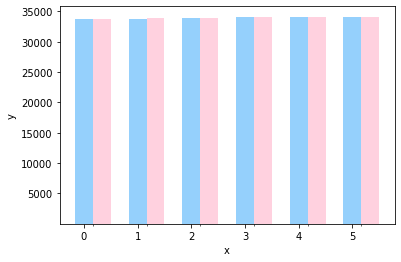

In [54]:
# male = (33820	33824	33907	34075	34052	34059)
# female = (33835	33846	33943	34137	34114	34121)
maleFemaleCombined = ((33820, 33835), (33824, 33846), (33907, 33943), (34075, 34137), (34052, 34114), (34059, 34121))
dim = len(maleFemaleCombined)
w = 2
dimw = w / dim

fig, ax = plt.subplots()
x = np.arange(len(maleFemaleCombined))
for i in range(len(maleFemaleCombined[0])):
    # light blue and pink
    color = 'xkcd:light blue' if i == 0 else 'xkcd:light pink'
    y = [d[i] for d in maleFemaleCombined]
    b = ax.bar(x + i * dimw, y, dimw, bottom=0.001, color = color)

ax.set_xticks(x + dimw / 2, map(str, x))
# ax.set_yscale('log')

ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

Disregarding party, both sexes at any given age are targeted with relatively minor differences, whereas age playing a slightly larger role.

### 2e: Ad Count by Age and Party

In [55]:
# republicans
%%bigquery --project $project_id

select
  (
  select
    sum(array_length(split(ads_list, ","))) as number_ads_targeting_ageRange
  from
    `bigquery-public-data.google_political_ads.campaign_targeting`
  where 
    age_targeting like "%18–24%"
    and advertiser_id in (
    'AR488306308034854912',
    'AR230475229367894016',
    'AR470291909525372928',
    'AR105500339708362752',
    'AR120847323008860160',
    'AR157291735423123456',
    'AR194446432348930048',
    'AR276637125548441600',
    'AR424466463902924800',
    'AR89517838687010816') 
  ) as ages18To24_Republicans,

  (
  select
    sum(array_length(split(ads_list, ",")))
  from
    `bigquery-public-data.google_political_ads.campaign_targeting`
  where 
    age_targeting like "%25–34%"
    and advertiser_id in (
    'AR488306308034854912',
    'AR230475229367894016',
    'AR470291909525372928',
    'AR105500339708362752',
    'AR120847323008860160',
    'AR157291735423123456',
    'AR194446432348930048',
    'AR276637125548441600',
    'AR424466463902924800',
    'AR89517838687010816') 
  ) as ages25To34_R,
  (
  select
    sum(array_length(split(ads_list, ",")))
  from
    `bigquery-public-data.google_political_ads.campaign_targeting`
  where 
    age_targeting like "%35–44%"
    and advertiser_id in (
    'AR488306308034854912',
    'AR230475229367894016',
    'AR470291909525372928',
    'AR105500339708362752',
    'AR120847323008860160',
    'AR157291735423123456',
    'AR194446432348930048',
    'AR276637125548441600',
    'AR424466463902924800',
    'AR89517838687010816')  
  ) as ages34To44_R,

  (select
    sum(array_length(split(ads_list, ",")))
  from
    `bigquery-public-data.google_political_ads.campaign_targeting`
  where 
    age_targeting like "%45–54%"
    and advertiser_id in (
    'AR488306308034854912',
    'AR230475229367894016',
    'AR470291909525372928',
    'AR105500339708362752',
    'AR120847323008860160',
    'AR157291735423123456',
    'AR194446432348930048',
    'AR276637125548441600',
    'AR424466463902924800',
    'AR89517838687010816') 
  ) as ages45To54_R,

  (select
    sum(array_length(split(ads_list, ",")))
  from
    `bigquery-public-data.google_political_ads.campaign_targeting`
  where 
    age_targeting like "%55–64%"
    and advertiser_id in (
    'AR488306308034854912',
    'AR230475229367894016',
    'AR470291909525372928',
    'AR105500339708362752',
    'AR120847323008860160',
    'AR157291735423123456',
    'AR194446432348930048',
    'AR276637125548441600',
    'AR424466463902924800',
    'AR89517838687010816') 
  ) as ages55To64_R,

  (select 
    sum(array_length(split(ads_list, ",")))
  from
    `bigquery-public-data.google_political_ads.campaign_targeting`
  where 
    age_targeting like "%65%"
    and advertiser_id in (
    'AR488306308034854912',
    'AR230475229367894016',
    'AR470291909525372928',
    'AR105500339708362752',
    'AR120847323008860160',
    'AR157291735423123456',
    'AR194446432348930048',
    'AR276637125548441600',
    'AR424466463902924800',
    'AR89517838687010816') 
  ) as ages65Plus_R


,ages18To24_Republicans,ages25To34_R,ages34To44_R,ages45To54_R,ages55To64_R,ages65Plus_R
0,38477,38561,39084,39191,39370,39408


In [56]:
# democrats
%%bigquery --project $project_id

select
  (
  select
    sum(array_length(split(ads_list, ","))) as number_ads_targeting_ageRange
  from
    `bigquery-public-data.google_political_ads.campaign_targeting`
  where 
    age_targeting like "%18–24%"
    and advertiser_id in (
    'AR458000056721604608',
    'AR432709227698454528',
    'AR101121809528651776',
    'AR140403236820484096',
    'AR485896728302583808',
    'AR329053043867779072',
    'AR383080296477622272',
    'AR271344076572327936',
    'AR492809907662225408',
    'AR50710026028843008'
    ) 
  ) as ages18To24_Democrats,

  (
  select
    sum(array_length(split(ads_list, ",")))
  from
    `bigquery-public-data.google_political_ads.campaign_targeting`
  where 
    age_targeting like "%25–34%"
    and advertiser_id in (
    'AR458000056721604608',
    'AR432709227698454528',
    'AR101121809528651776',
    'AR140403236820484096',
    'AR485896728302583808',
    'AR329053043867779072',
    'AR383080296477622272',
    'AR271344076572327936',
    'AR492809907662225408',
    'AR50710026028843008'
    )
  ) as ages25To34_D,
  (
  select
    sum(array_length(split(ads_list, ",")))
  from
    `bigquery-public-data.google_political_ads.campaign_targeting`
  where 
    age_targeting like "%35–44%"
    and advertiser_id in (
    'AR458000056721604608',
    'AR432709227698454528',
    'AR101121809528651776',
    'AR140403236820484096',
    'AR485896728302583808',
    'AR329053043867779072',
    'AR383080296477622272',
    'AR271344076572327936',
    'AR492809907662225408',
    'AR50710026028843008'
    )
  ) as ages34To44_D,

  (select
    sum(array_length(split(ads_list, ",")))
  from
    `bigquery-public-data.google_political_ads.campaign_targeting`
  where 
    age_targeting like "%45–54%"
    and advertiser_id in (
    'AR458000056721604608',
    'AR432709227698454528',
    'AR101121809528651776',
    'AR140403236820484096',
    'AR485896728302583808',
    'AR329053043867779072',
    'AR383080296477622272',
    'AR271344076572327936',
    'AR492809907662225408',
    'AR50710026028843008'
    )
  ) as ages45To54_D,

  (select
    sum(array_length(split(ads_list, ",")))
  from
    `bigquery-public-data.google_political_ads.campaign_targeting`
  where 
    age_targeting like "%55–64%"
    and advertiser_id in (
    'AR458000056721604608',
    'AR432709227698454528',
    'AR101121809528651776',
    'AR140403236820484096',
    'AR485896728302583808',
    'AR329053043867779072',
    'AR383080296477622272',
    'AR271344076572327936',
    'AR492809907662225408',
    'AR50710026028843008'
    )
  ) as ages55To64_D,

  (select 
    sum(array_length(split(ads_list, ",")))
  from
    `bigquery-public-data.google_political_ads.campaign_targeting`
  where 
    age_targeting like "%65%"
    and advertiser_id in (
    'AR458000056721604608',
    'AR432709227698454528',
    'AR101121809528651776',
    'AR140403236820484096',
    'AR485896728302583808',
    'AR329053043867779072',
    'AR383080296477622272',
    'AR271344076572327936',
    'AR492809907662225408',
    'AR50710026028843008'
    )
  ) as ages65Plus_D



,ages18To24_Democrats,ages25To34_D,ages34To44_D,ages45To54_D,ages55To64_D,ages65Plus_D
0,2653,2653,2682,2807,2781,2771


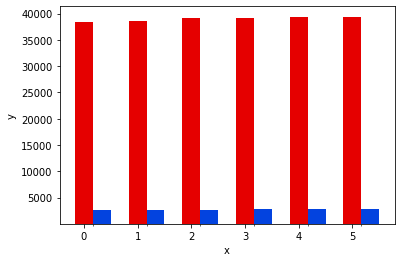

In [57]:
# rep = 38477	38561	39084	39191	39370	39408
# dem = 2653	2653	2682	2807	2781	2771
combined = ((38477, 2653), (38561, 2653), (39084, 2682), (39191, 2807), (39370, 2781), (39408, 2771))
dim = len(combined)
w = 2
dimw = w / dim

fig, ax = plt.subplots()
x = np.arange(len(combined))
for i in range(len(combined[0])):
    color = 'xkcd:red' if i == 0 else 'xkcd:blue'

    y = [d[i] for d in combined]
    b = ax.bar(x + i * dimw, y, dimw, bottom=0.001, color=color)

ax.set_xticks(x + dimw / 2, map(str, x))

ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

This discrepancy in ad counts for age targeting of groups between Republicans and Democrats is orders larger than the difference in overall ad counts seen previously. There are several possible explanations for this. Two, which lead to different conclusions: include:
1. The `age_targeting` for Democrats is left as "Not targeted".
2. Democrats, instead of selecting multiple age categories for each ad, select only one precise range, so Republicans can quadruple count each ad as it appears to multiple age groups.

Regardless, this does not change the overall stats of who is proportionally targeted by each party. To better see these differences in targeting, let's scale this by normalizing the total number of ads across parties.

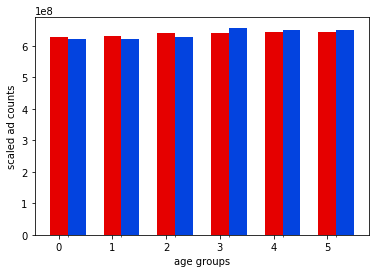

In [59]:
rep = (38477,	38561,	39084,	39191,	39370,	39408)
dem = (2653,	2653,	2682,	2807,	2781,	2771)
combinedRD = ((38477, 2653), (38561, 2653), (39084, 2682), (39191, 2807), (39370, 2781), (39408, 2771))

dim = len(combinedRD)
w = 2
dimw = w / dim

fig, ax = plt.subplots()
x = np.arange(len(combinedRD))
for i in range(len(combinedRD[0])):
    if i == 0:
      y = [d[i] * sum(dem) for d in combinedRD]
    else:
      y = [d[i] * sum(rep) for d in combinedRD]
    color = 'xkcd:red' if i == 0 else 'xkcd:blue'
    b = ax.bar(x + i * dimw, y, dimw, bottom=0.001, color=color)

ax.set_xticks(x + dimw / 2, map(str, x))

ax.set_xlabel('age groups')
ax.set_ylabel('scaled ad counts')

plt.show()

With this normalization, we can see that while Republicans roughly target all ages equally, Democrats target groups above 35 more than those under 35. 

### 2f. Ad Count by Sex and Party

In [60]:
%%bigquery --project $project_id


select

(select
  sum(array_length(split(ads_list, ",")))
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where
  gender_targeting like "%Male%"
  and advertiser_id in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816')) as maleRep,
  
(select
  sum(array_length(split(ads_list, ",")))
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where
  gender_targeting like "%Female%"
  and advertiser_id in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816')) as femaleRep,
  
(select
  sum(array_length(split(ads_list, ",")))
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where
  gender_targeting like "%Male%"
  and advertiser_id in (
  'AR458000056721604608',
  'AR432709227698454528',
  'AR101121809528651776',
  'AR140403236820484096',
  'AR485896728302583808',
  'AR329053043867779072',
  'AR383080296477622272',
  'AR271344076572327936',
  'AR492809907662225408',
  'AR50710026028843008')) as maleDem,
  
(select
  sum(array_length(split(ads_list, ",")))
from
  `bigquery-public-data.google_political_ads.campaign_targeting`
where
  gender_targeting like "%Female%"
  and advertiser_id in (
  'AR458000056721604608',
  'AR432709227698454528',
  'AR101121809528651776',
  'AR140403236820484096',
  'AR485896728302583808',
  'AR329053043867779072',
  'AR383080296477622272',
  'AR271344076572327936',
  'AR492809907662225408',
  'AR50710026028843008')) as femaleDem
  
  
  
  

,maleRep,femaleRep,maleDem,femaleDem
0,31739,31758,2479,2561


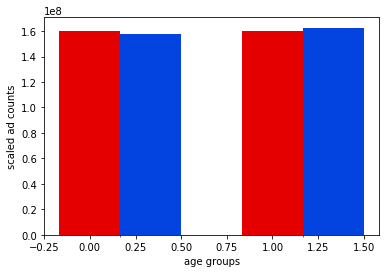

In [62]:
rep = (31739,	31758)
dem = (2479,	2561)

combinedReDe = ((31739, 2479), (31758, 2561))

dim = len(combined)
w = 2
dimw = w / dim

fig, ax = plt.subplots()
x = np.arange(len(combinedReDe))
for i in range(len(combinedReDe[0])):
    color = 'xkcd:red' if i == 0 else 'xkcd:blue'
    if i == 0:
      y = [d[i] * sum(dem) for d in combinedReDe]
    else:
      y = [d[i] * sum(rep) for d in combinedReDe]
    b = ax.bar(x + i * dimw, y, dimw, bottom=0.001, color=color)

ax.set_xticks(x + dimw / 2, map(str, x))

ax.set_xlabel('left: males(R,D), right: females: (R,D)')
ax.set_ylabel('ad counts')

plt.show()

The Republican party's ads target males slightly more than Democrats do, and the Democrats' target females slightly more than Reublicans do. 

## Data Prediction

---

Given an ad campaign with demographic targeting data, predict/classify the party responsible for ad.

For this, we use the `campaign_targeting` dataset, with the `age_targeting`, `gender_targeting`, `geo_targeting_included` and `geo_targeting_excluded` fields as features. We limit the dataset to know, classified political parties (as previously, the top 5 for each). This is further divided into train, eval, and prediction sets by `campaign_id`'s last digit, which is a way to randomly but consistently divide. Specifically, train where `campaign_id` ends in 1, 2, 3, 4, 5, 6, eval where `campaign_id` ends in 7, 8, and 
predict where `campaign_id` ends in 9, 0.

---

### Set up Dataset

In [6]:
model_dataset_name = 'party_predictor'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

Dataset(DatasetReference('cs145-p3-actual', 'party_predictor'))

### Model 1
First, let's try a model predicting political party based just off gender and age.

In [69]:
# 0 if dem, 1 if rep

%%bigquery --project $project_id

CREATE OR REPLACE MODEL `party_predictor.pa_pr_model_1`
OPTIONS(model_type='logistic_reg') AS

select 
  age_targeting,
  gender_targeting,

  if (advertiser_id in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816'), 1, 0) as label

from 
`bigquery-public-data.google_political_ads.campaign_targeting`

where
  (advertiser_id in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816',
  'AR458000056721604608',
  'AR432709227698454528',
  'AR101121809528651776',
  'AR140403236820484096',
  'AR485896728302583808',
  'AR329053043867779072',
  'AR383080296477622272',
  'AR271344076572327936',
  'AR492809907662225408',
  'AR50710026028843008'
  )) and (
  campaign_id like "%1"
  or campaign_id like "%2"
  or campaign_id like "%3"
  or campaign_id like "%4"
  or campaign_id like "%5"
  or campaign_id like "%6"
  )


""


In [70]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `party_predictor.pa_pr_model_1`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,5,0.597166,0.602906,6.4,5336
1,0,4,0.603014,0.606270,3.2,3728
2,0,3,0.614507,0.613718,1.6,5880
3,0,2,0.635066,0.632907,0.8,7419
4,0,1,0.659676,0.658043,0.4,6483
5,0,0,0.679982,0.679277,0.2,4304


#### Now let's evaluate this second model.

In [72]:
# 0 if dem, 1 if rep

%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `party_predictor.pa_pr_model_1`, (
    select 
      age_targeting,
      gender_targeting,

      if (advertiser_id in (
      'AR488306308034854912',
      'AR230475229367894016',
      'AR470291909525372928',
      'AR105500339708362752',
      'AR120847323008860160',
      'AR157291735423123456',
      'AR194446432348930048',
      'AR276637125548441600',
      'AR424466463902924800',
      'AR89517838687010816'), 1, 0) as label

    from 
    `bigquery-public-data.google_political_ads.campaign_targeting`

    where
      (advertiser_id in (
      'AR488306308034854912',
      'AR230475229367894016',
      'AR470291909525372928',
      'AR105500339708362752',
      'AR120847323008860160',
      'AR157291735423123456',
      'AR194446432348930048',
      'AR276637125548441600',
      'AR424466463902924800',
      'AR89517838687010816',
      'AR458000056721604608',
      'AR432709227698454528',
      'AR101121809528651776',
      'AR140403236820484096',
      'AR485896728302583808',
      'AR329053043867779072',
      'AR383080296477622272',
      'AR271344076572327936',
      'AR492809907662225408',
      'AR50710026028843008'
      )) and (
      campaign_id like "%7"
      or campaign_id like "%8"
      )
    )
  )

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.777159,0.584293,0.658492,0.667065,0.607034,0.506427


Not great. While sex and gender provide some indication as to political party, they are only 65% accurate.

Let's try adding geographic information.

### Model, take two.
Add geographic information as a feature, then train on training subset.

In [63]:
# 0 if dem, 1 if rep

%%bigquery --project $project_id

CREATE OR REPLACE MODEL `party_predictor.pa_pr_model`
OPTIONS(model_type='logistic_reg') AS

select 
  age_targeting,
  gender_targeting,
  geo_targeting_included,
  geo_targeting_excluded,

  if (advertiser_id in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816'), 1, 0) as label

from 
`bigquery-public-data.google_political_ads.campaign_targeting`

where
  (advertiser_id in (
  'AR488306308034854912',
  'AR230475229367894016',
  'AR470291909525372928',
  'AR105500339708362752',
  'AR120847323008860160',
  'AR157291735423123456',
  'AR194446432348930048',
  'AR276637125548441600',
  'AR424466463902924800',
  'AR89517838687010816',
  'AR458000056721604608',
  'AR432709227698454528',
  'AR101121809528651776',
  'AR140403236820484096',
  'AR485896728302583808',
  'AR329053043867779072',
  'AR383080296477622272',
  'AR271344076572327936',
  'AR492809907662225408',
  'AR50710026028843008'
  )) and (
  campaign_id like "%1"
  or campaign_id like "%2"
  or campaign_id like "%3"
  or campaign_id like "%4"
  or campaign_id like "%5"
  or campaign_id like "%6"
  )


""


In [65]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `party_predictor.pa_pr_model`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,7,0.205651,0.271389,6.4,4105
1,0,6,0.208861,0.274066,12.8,3150
2,0,5,0.232724,0.293928,6.4,4143
3,0,4,0.282739,0.336344,3.2,4041
4,0,3,0.368464,0.411239,1.6,4123
5,0,2,0.474331,0.504524,0.8,3750
6,0,1,0.571835,0.588781,0.4,3973
7,0,0,0.645636,0.652202,0.2,3971


#### Evaluate model performance

In [66]:
# 0 if dem, 1 if rep

%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `party_predictor.pa_pr_model`, (
    select 
      age_targeting,
      gender_targeting,
      geo_targeting_included,
      geo_targeting_excluded,

      if (advertiser_id in (
      'AR488306308034854912',
      'AR230475229367894016',
      'AR470291909525372928',
      'AR105500339708362752',
      'AR120847323008860160',
      'AR157291735423123456',
      'AR194446432348930048',
      'AR276637125548441600',
      'AR424466463902924800',
      'AR89517838687010816'), 1, 0) as label

    from 
    `bigquery-public-data.google_political_ads.campaign_targeting`

    where
      (advertiser_id in (
      'AR488306308034854912',
      'AR230475229367894016',
      'AR470291909525372928',
      'AR105500339708362752',
      'AR120847323008860160',
      'AR157291735423123456',
      'AR194446432348930048',
      'AR276637125548441600',
      'AR424466463902924800',
      'AR89517838687010816',
      'AR458000056721604608',
      'AR432709227698454528',
      'AR101121809528651776',
      'AR140403236820484096',
      'AR485896728302583808',
      'AR329053043867779072',
      'AR383080296477622272',
      'AR271344076572327936',
      'AR492809907662225408',
      'AR50710026028843008'
      )) and (
      campaign_id like "%7"
      or campaign_id like "%8"
      )
    )
  )

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.900315,0.898429,0.882281,0.899371,0.276213,0.942659


Significantly (~20%) better! Geographic region of an ad provides strong signal as to which party made that ad. In other words, Democrats and Republicans largely target different regions.

In other words, age, gender, and geographic targeting together are sufficient to predict Democrat (0) or Republican (1) advertising with 88% accuracy.

Let's evaluate this model on a test set, and look at some preditions.




#### Test Set Eval

In [73]:
# 0 if dem, 1 if rep

%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `party_predictor.pa_pr_model`, (
    select 
      age_targeting,
      gender_targeting,
      geo_targeting_included,
      geo_targeting_excluded,

      if (advertiser_id in (
      'AR488306308034854912',
      'AR230475229367894016',
      'AR470291909525372928',
      'AR105500339708362752',
      'AR120847323008860160',
      'AR157291735423123456',
      'AR194446432348930048',
      'AR276637125548441600',
      'AR424466463902924800',
      'AR89517838687010816'), 1, 0) as label

    from 
    `bigquery-public-data.google_political_ads.campaign_targeting`

    where
      (advertiser_id in (
      'AR488306308034854912',
      'AR230475229367894016',
      'AR470291909525372928',
      'AR105500339708362752',
      'AR120847323008860160',
      'AR157291735423123456',
      'AR194446432348930048',
      'AR276637125548441600',
      'AR424466463902924800',
      'AR89517838687010816',
      'AR458000056721604608',
      'AR432709227698454528',
      'AR101121809528651776',
      'AR140403236820484096',
      'AR485896728302583808',
      'AR329053043867779072',
      'AR383080296477622272',
      'AR271344076572327936',
      'AR492809907662225408',
      'AR50710026028843008'
      )) and (
      campaign_id like "%9"
      or campaign_id like "%0"
      )
    )
  )

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.932331,0.894845,0.900542,0.913204,0.240772,0.957754


Nice! The model still performs at ~90% accuracy.

#### Predict Samples for each party
Let's find examples of ad campaigns the model believes to be Republican

In [67]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.PREDICT(MODEL `party_predictor.pa_pr_model`,
  (
    select 
      age_targeting,
      gender_targeting,
      geo_targeting_included,
      geo_targeting_excluded

    from 
    `bigquery-public-data.google_political_ads.campaign_targeting`

    where
      (advertiser_id in (
      'AR488306308034854912',
      'AR230475229367894016',
      'AR470291909525372928',
      'AR105500339708362752',
      'AR120847323008860160',
      'AR157291735423123456',
      'AR194446432348930048',
      'AR276637125548441600',
      'AR424466463902924800',
      'AR89517838687010816',
      'AR458000056721604608',
      'AR432709227698454528',
      'AR101121809528651776',
      'AR140403236820484096',
      'AR485896728302583808',
      'AR329053043867779072',
      'AR383080296477622272',
      'AR271344076572327936',
      'AR492809907662225408',
      'AR50710026028843008'
      )) and (
      campaign_id like "%9"
      or campaign_id like "%0"
      )
    # limit 10
  )
)
where predicted_label = 1
limit 10

,predicted_label,predicted_label_probs,age_targeting,gender_targeting,geo_targeting_included,geo_targeting_excluded
0,1,"[{'label': 1, 'prob': 0.938653920761747}, {'la...",Not targeted,Not targeted,"AZ-1,Arizona,United States",Not targeted
1,1,"[{'label': 1, 'prob': 0.965311086021226}, {'la...",Not targeted,Not targeted,"IL-14,Illinois,United States",Not targeted
2,1,"[{'label': 1, 'prob': 0.960918645745057}, {'la...",Not targeted,Not targeted,"PA-8,Pennsylvania,United States",Not targeted
3,1,"[{'label': 1, 'prob': 0.9693616431435073}, {'l...",Not targeted,Not targeted,"TX-32,Texas,United States",Not targeted
4,1,"[{'label': 1, 'prob': 0.938653920761747}, {'la...",Not targeted,Not targeted,"MN-7,Minnesota,United States",Not targeted
5,1,"[{'label': 1, 'prob': 0.9945228249596492}, {'l...","18–24, 25–34, 35–44, 45–54, 55–64, ≥65, Unknow...","Male, Female, Unknown gender","OH-12,Ohio,United States",Not targeted
6,1,"[{'label': 1, 'prob': 0.9945228249596492}, {'l...","18–24, 25–34, 35–44, 45–54, 55–64, ≥65, Unknow...","Male, Female, Unknown gender","OH-12,Ohio,United States",Not targeted
7,1,"[{'label': 1, 'prob': 0.9945228249596492}, {'l...","18–24, 25–34, 35–44, 45–54, 55–64, ≥65, Unknow...","Male, Female, Unknown gender","OH-12,Ohio,United States",Not targeted
8,1,"[{'label': 1, 'prob': 0.9795698083206893}, {'l...","45–54, 55–64, ≥65",Not targeted,"12770, 18058, 18071, 18201, 18202, 18210, 1821...",Not targeted
9,1,"[{'label': 1, 'prob': 0.9596549322791469}, {'l...","18–24, 25–34, 35–44, 45–54, 55–64, ≥65, Unknow...","Male, Female, Unknown gender","12770, 18058, 18071, 18201, 18202, 18210, 1821...",New York


Similarly, let's find examples the model believes Democrat.

In [68]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.PREDICT(MODEL `party_predictor.pa_pr_model`,
  (
    select 
      age_targeting,
      gender_targeting,
      geo_targeting_included,
      geo_targeting_excluded

    from 
    `bigquery-public-data.google_political_ads.campaign_targeting`

    where
      (advertiser_id in 
      (
      'AR432709227698454528',
      'AR101121809528651776',
      'AR140403236820484096',
      'AR485896728302583808',
      'AR329053043867779072'
      ) or advertiser_id in(
      'AR488306308034854912',
      'AR230475229367894016',
      'AR120847323008860160',
      'AR470291909525372928',
      'AR105500339708362752'
      )) and (
      campaign_id like "%9"
      or campaign_id like "%0"
      )
    # limit 10
  )
)
where predicted_label = 0
limit 10

,predicted_label,predicted_label_probs,age_targeting,gender_targeting,geo_targeting_included,geo_targeting_excluded
0,0,"[{'label': 1, 'prob': 0.1516573193682295}, {'l...",Not targeted,Not targeted,United States,Not targeted
1,0,"[{'label': 1, 'prob': 0.1516573193682295}, {'l...",Not targeted,Not targeted,United States,Not targeted
2,0,"[{'label': 1, 'prob': 0.1516573193682295}, {'l...",Not targeted,Not targeted,United States,Not targeted
3,0,"[{'label': 1, 'prob': 0.1516573193682295}, {'l...",Not targeted,Not targeted,United States,Not targeted
4,0,"[{'label': 1, 'prob': 0.1516573193682295}, {'l...",Not targeted,Not targeted,United States,Not targeted
5,0,"[{'label': 1, 'prob': 0.1516573193682295}, {'l...",Not targeted,Not targeted,United States,Not targeted
6,0,"[{'label': 1, 'prob': 0.1516573193682295}, {'l...",Not targeted,Not targeted,United States,Not targeted
7,0,"[{'label': 1, 'prob': 0.1516573193682295}, {'l...",Not targeted,Not targeted,United States,Not targeted
8,0,"[{'label': 1, 'prob': 0.1516573193682295}, {'l...",Not targeted,Not targeted,United States,Not targeted
9,0,"[{'label': 1, 'prob': 0.06399598060538209}, {'...",Not targeted,Not targeted,Washington,Not targeted


## Conclusion

---
From our explorations, we discovered meaningful differences in gender, age, and geographic targeting across Democrat and Republican political parties in the US.

In recap:
- Republicans advertise ~50% more than Democrats. 
- Florida, California, and Texas are the most targeted states.
- Females are targeted slightly more than males.
- Age is highly relevant, where those below 25 or above 65 years old are targeted less than those between.
- Republicans target males more than females, and Democrats target females more than males.
- Democrats target those aged 35+ more than those under 35, whereas Republicans target all ages roughly the same. 


We then defined a model which took just these demographic features for an ad campaign, and could successfully predict whether the campaign was Democratic or Republican 87% of the time.

However, it's important to remember that the partisan classification was limited. It's possible that the top 10 donors do not represent the entirety of each party, especially since we observed a shift in total spending for each party as we increased the number of advertisers in consideration from 5 to 10.

It's also relevant that these top donors are in flux, and that they are not cohesive. Different political candidates within the same party can have different messages with different target audiences. The fact that Bloomberg can appear suddenly, for example, demonstrates such potential for destabilization.

Nonetheless, overall there remain clear trends of demographic ad targeting between Republicans and Democrats.


---